## Introduction to using JAMS with Music21

In this notebook we will cover using the JAMS file format with Music21. **JAMS** are a formal **J**SON **A**nnotated **M**usic **S**pecification for Reproducible MIR Research. Each file stores time-aligned musical annotations (like chords, beats, segments, tags etc.). This notebook shows how to go from JAMS chord annotations → music21 objects → analysis/visualization.

### Extra resources
- [JAMS Documentation](https://jams.readthedocs.io/en/stable/)
- [JAMS Repository](https://github.com/marl/jams)



In [ ]:
from pathlib import Path

import jams
from harte.harte import Harte
from music21 import chord, key, meter, stream

In [2]:
# define paths
DATA_PATH = Path("../data")
JAMS_PATH = DATA_PATH / "jams"
JSON_PATH = DATA_PATH / "json"

### Loading a JAMS file

The JAMS library lets you define a custom namespsace. A namespace defines the syntax of a particular type of annotation. JAMS ships with some [predefined namespaces](https://jams.readthedocs.io/en/stable/namespace.html#namespace). For more information see the [documentation](https://jams.readthedocs.io/en/stable/namespace_structure.html).

For this example we add a namespace defined in `timesig.json`. This adds support for `timesig` annotations and their values must be of the form `{numerator, denominator}`.

In [3]:
# allow JAMS to recognize the time signature namespace
jams.schema.add_namespace(str(JSON_PATH / "timesig.json"))

Load a `.jams` file using the JAMS library

In [4]:
file_name = JAMS_PATH / "biab-internet-corpus_1.jams"

jam = jams.load(str(file_name), validate=False)

# print some metadata from the jam
print("Title:", jam.file_metadata.title)
print("Artist:", jam.file_metadata.artist)

Title: All God's Chillun Got Rhythm
Artist: Walter Jurmann


In [5]:
# get the chord annotations from the jam
chords = jam.annotations[0].data
print(f"The track contains {len(chords)} chords")

The track contains 53 chords


### Parsing chords with the Harte library

Now that we have the chords loaded from the JAMS file, we can use the harte library to convert harte chords into music21 chords. The Harte Library is an extension of the music21 library tailored for working with music chords encoded according to the [Harte Notation](https://ismir2005.ismir.net/proceedings/1080.pdf).

In [ ]:
# Convert the chord annotations to a list of music21 Chord objects

music21_chords = []

# Iterate over the chord annotations
for chord_data in chords:
    label = chord_data.value

    # Skip chords with no label
    if label == "N":
        continue

    # Decompose the onset information of the chord
    onset = chord_data.time
    beat, measure = str(onset).split(".")

    # Create a music21 Chord object from the Harte label
    harte_chord = Harte(label)
    pitches = harte_chord.pitches
    music21_chord = chord.Chord(pitches, quarterLength=float(chord_data.duration))

    music21_chords.append(music21_chord)
    print(f"{music21_chord.fullName} - Type: {music21_chord.duration.type}")

Chord {C in octave 4 | E in octave 4 | G in octave 4 | B in octave 4} Half - Type: half
Chord {A in octave 4 | C in octave 5 | E in octave 5 | G in octave 5} Half - Type: half
Chord {D in octave 4 | F in octave 4 | A in octave 4 | C in octave 5} Half - Type: half
Chord {G in octave 4 | B in octave 4 | D in octave 5 | F in octave 5} Half - Type: half
Chord {E in octave 4 | G in octave 4 | B in octave 4 | D in octave 5} Half - Type: half
Chord {A in octave 4 | C-sharp in octave 5 | E in octave 5 | G in octave 5 | B-flat in octave 4} Half - Type: half
Chord {D in octave 4 | F in octave 4 | A in octave 4 | C in octave 5} Half - Type: half
Chord {G in octave 4 | B in octave 4 | D in octave 5 | F in octave 5} Half - Type: half
Chord {C in octave 4 | E in octave 4 | G in octave 4 | B in octave 4} Half - Type: half
Chord {A in octave 4 | C in octave 5 | E in octave 5 | G in octave 5} Half - Type: half
Chord {D in octave 4 | F in octave 4 | A in octave 4 | C in octave 5} Half - Type: half
Chord

We can now have a look at the attributes of a specific chord.

In [7]:
# print attributes for the first chord
print("Full chord name:", music21_chords[0].fullName)
print("Pitched common name:", music21_chords[0].pitchedCommonName)
print("Root:", music21_chords[0].root())
print("Bass:", music21_chords[0].bass())
print("Inversion:", music21_chords[0].inversion())
print("Duration (quarter length):", music21_chords[0].duration.quarterLength)

Full chord name: Chord {C in octave 4 | E in octave 4 | G in octave 4 | B in octave 4} Half
Pitched common name: C-major seventh chord
Root: C4
Bass: C4
Inversion: 0
Duration (quarter length): 2.0


### Extracting time and key signatures

Extract from the JAMS file time signature and key information. To find them, we need to search for the `"key"` and `"timesig"` namespace in the JAMS file. We will then convert them into the corresponding music21 format.

In [8]:
# Extract and print the time signature
timesig = jam.search(namespace="timesig")[0].data

# Convert JAMS time signature to music21 format
numerator = timesig[0].value["numerator"]
denominator = timesig[0].value["denominator"]
time_signature = meter.TimeSignature(f"{numerator}/{denominator}")

print(time_signature)

<music21.meter.TimeSignature 4/4>


In [9]:
# Extract key information
keysig = jam.search(namespace="key")[0].data[0].value

# Convert JAMS format ("C:major") to music21 format ("C major")
tonic, mode = keysig.split(":")
music21_key = key.Key(tonic, mode)

print(music21_key)

C major


### Display the score

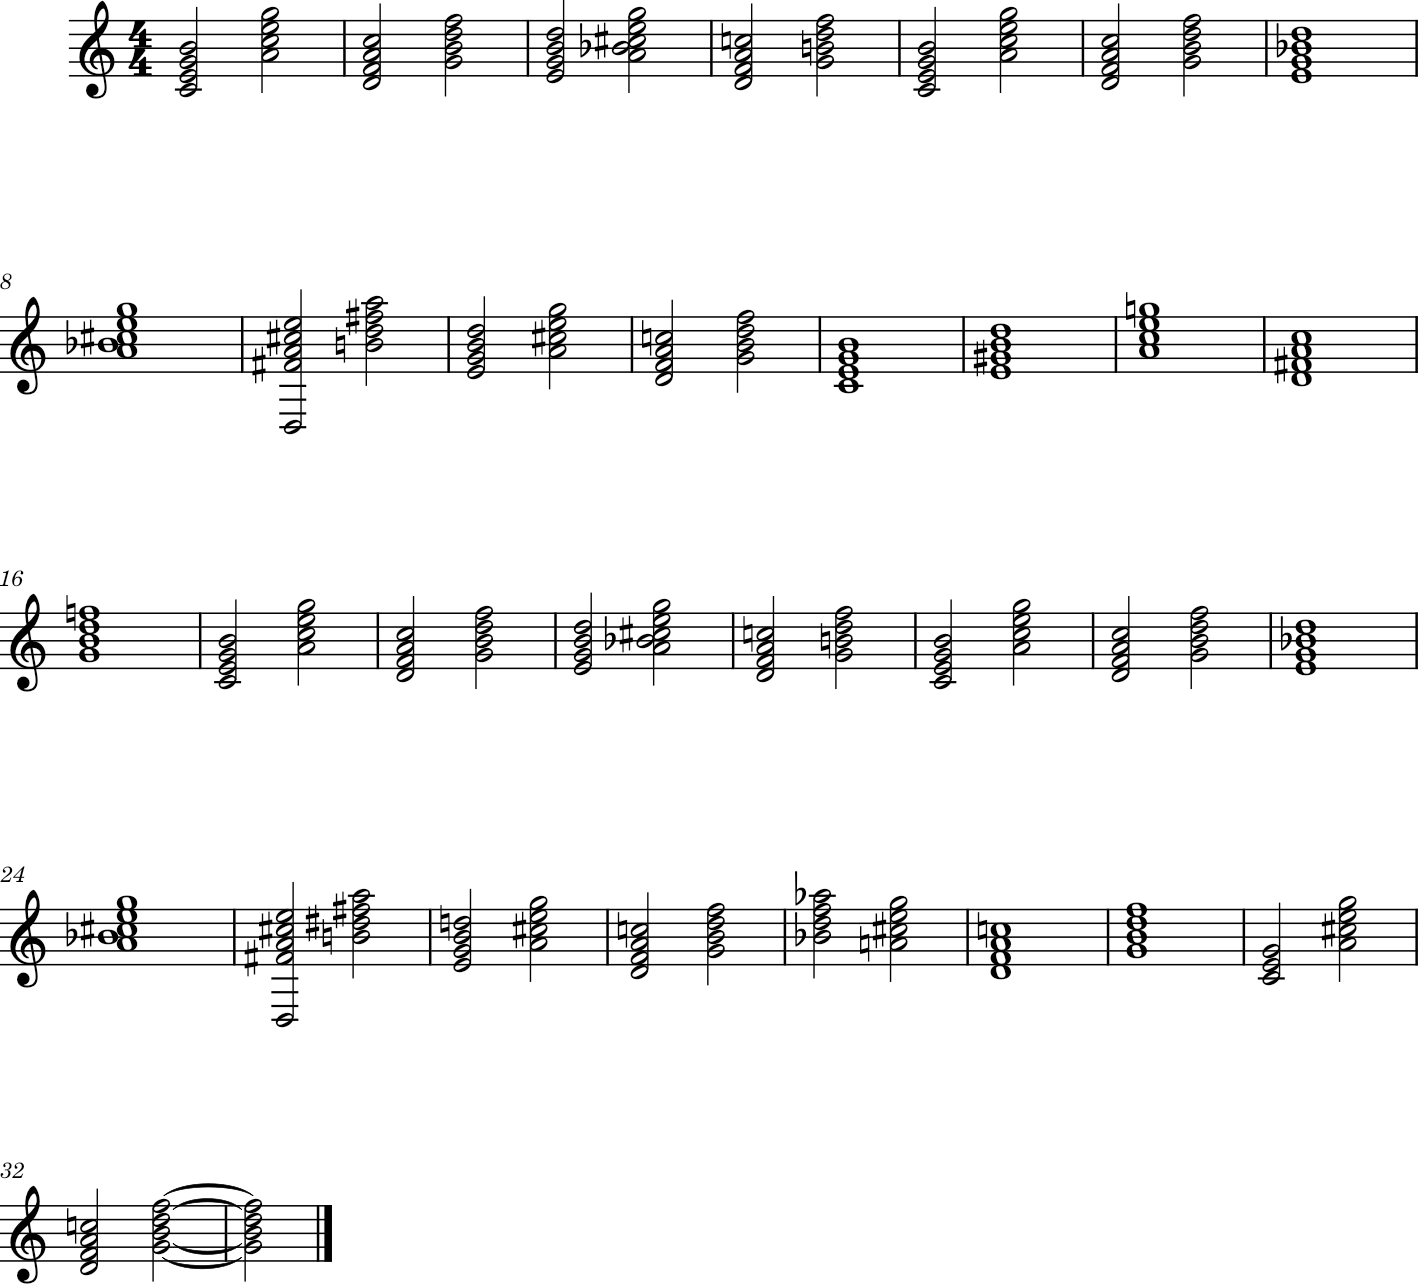

In [10]:
# create a music21 stream with the chords
s = stream.Stream()

# add key and time signature
s.append(music21_key)
s.append(time_signature)

# add chords
for music21_chord in music21_chords:
    s.append(music21_chord)

s.show()
